In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 13

# Prepare

In [3]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

In [4]:
nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [5]:
df_range = pd.read_csv('saprc99_range.csv', index_col=0)
df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range.head(10)

,min,max,mid
H2SO4,2.131631e+10,1.223799e+12,6.225577e+11
HCOOH,1.941420e+10,1.137429e+11,6.657857e+10
CCO_OH,2.994973e+10,2.073705e+12,1.051827e+12
RCO_OH,1.275993e+10,1.380322e+12,6.965411e+11
CCO_OOH,8.695723e+05,1.215977e+12,6.079890e+11
RCO_OOH,4.160388e+05,7.387218e+11,3.693611e+11
XN,5.950410e+07,2.010207e+11,1.005401e+11
XC,4.906034e+12,5.593960e+12,5.249997e+12
SO2,8.404868e+05,1.202484e+12,6.012423e+11
O1D,1.000000e-08,7.012137e-01,3.506069e-01


# Sensitivity matrix on reference point

In [6]:
y0 = np.append(df_range['mid'], 0.5)
#y0 = np.random.uniform(np.append(df_range['min'], 0), np.append(df_range['max'], 1))

y0.shape

(75,)

In [7]:
f0 = kpp.onestep(y0.T).T
f0.shape

(1, 74)

In [8]:
y_perturb = np.empty([75, 75])
y_perturb[:] = y0
for i in range(75):
    y_perturb[i, i] *= 1.1

In [9]:
f = kpp.onestep(y_perturb.T).T
f.shape

(75, 74)

In [10]:
A = f/f0 # sensitivity matrix

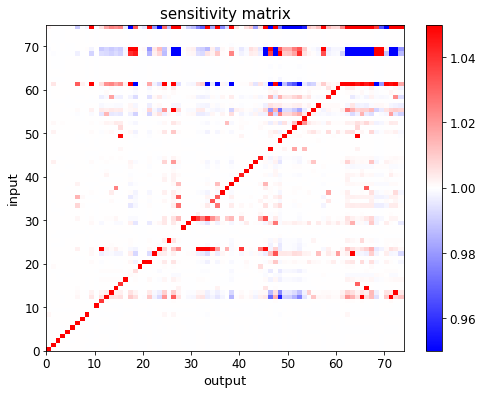

In [11]:
plt.figure(figsize=[8, 6])
plt.pcolormesh(A, cmap='bwr', vmin=0.95, vmax=1.05)
plt.colorbar()
plt.ylabel('input')
plt.xlabel('output')
plt.title('sensitivity matrix')

# Identify important input variable

In [12]:
# each output variable is impacted by how many input variables
for thres in [0.01, 0.02, 0.05]:
    print(thres, '\n', (np.abs(A - 1.0) > thres).sum(axis=0))

0.01 
 [ 1  1  1  1  1  1  4  1  1  2  1  3  4  5  4  5  1  5  4  1  1  6  2  3  6
  2  9  8  1  1  2  3  3  5  4  8  2  3  6  1  3  1  2  2  3  6 11  9 10  5
  5 10 10  4  3  3  3  3  3  1  2  2  7  8  6  6  6 10  4  4  4  6  7  5]
0.02 
 [1 1 1 1 1 1 2 1 1 2 1 2 2 3 3 4 1 4 4 1 1 3 2 2 4 1 6 6 1 1 1 3 3 4 3 4 2
 1 4 1 2 1 1 1 2 5 8 6 9 2 3 4 6 3 1 1 1 3 1 1 1 2 6 5 6 5 6 4 4 4 2 5 6 2]
0.05 
 [1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 3 2 1 1 2 1 2 1 1 5 3 1 1 1 1 1 3 0 2 1
 1 3 1 0 1 1 1 0 3 3 4 3 2 2 2 3 1 1 1 1 2 0 1 1 1 4 4 4 5 4 4 3 2 2 4 5 1]


In [13]:
# each input variable can impact how many output variables
for thres in [0.01, 0.02, 0.05]:
    print(thres, '\n', (np.abs(A - 1.0) > thres).sum(axis=1))

0.01 
 [ 1  1  1  1  1  1  1  1  1  0  1  1 19  6  2  2  1  0  0  1  3  0  6 15  0
  1  0  0  1  4 11  0  0  2  1  3  2  3  4  1  1  1  1  4  1  0  3  0  1  3
  2  1  4  1  8 12  1  0  6  1  1 35  0  0  0  0  0  0 29 31  0  0  0  0 51]
0.02 
 [ 1  1  1  1  1  1  1  1  1  0  1  1  9  3  2  2  1  0  0  1  2  0  3 10  0
  1  0  0  1  2  6  0  0  2  1  2  1  3  1  1  1  1  1  1  1  0  1  0  1  3
  1  1  2  1  3  6  1  0  2  1  1 30  0  0  0  0  0  0 21 23  0  0  0  0 41]
0.05 
 [ 1  1  1  1  1  1  1  1  1  0  1  0  3  2  2  0  1  0  0  1  2  0  1  5  0
  1  0  0  1  1  1  0  0  0  0  0  1  1  1  1  0  1  1  1  0  0  1  0  1  2
  1  1  1  1  1  2  1  0  0  1  1 20  0  0  0  0  0  0 15 17  0  0  0  0 27]


In [14]:
impact_factor = (np.abs(A - 1.0) > 0.02).sum(axis=1)
df_impact = pd.Series(impact_factor, index=varnames+['SUN'])

In [15]:
df_impact[df_impact>=5]

PAN      9
ARO2    10
ARO1     6
HCHO     6
O3      30
NO      21
NO2     23
SUN     41
dtype: int64

# Sensitivity on multiple points

In [16]:
def sensitivity(perb=1.1, thres=0.01):
    y0 = np.random.uniform(np.append(df_range['min'], 0), np.append(df_range['max'], 1))
    f0 = kpp.onestep(y0.T).T

    y_perturb = np.empty([75, 75])
    y_perturb[:] = y0
    for i in range(75):
        y_perturb[i, i] *= perb

    f = kpp.onestep(y_perturb.T).T

    A = f/f0 # sensitivity matrix
    
    n_effect = (np.abs(A - 1.0) > thres).sum(axis=0)
    return n_effect.mean(), n_effect.max()

In [17]:
%%time
n_max_ls = []
n_mean_ls = []

for i in range(200):
    n_mean, n_max = sensitivity()
    n_max_ls.append(n_max)
    n_mean_ls.append(n_mean)

CPU times: user 12.3 s, sys: 30.9 ms, total: 12.4 s
Wall time: 12.4 s


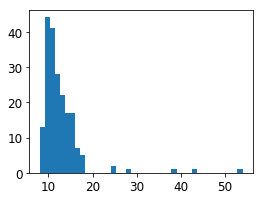

In [18]:
plt.hist(n_max_ls, bins=40);

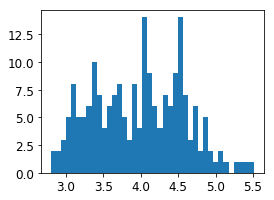

In [19]:
plt.hist(n_mean_ls, bins=40);